# Song lyrics exploration - Part 2: Lexical diversity

This part explores the [lexical diversity](https://en.wikipedia.org/wiki/Lexical_diversity) of different metal genres and bands. A few different methods are used to quantify lexical diversity in order to answer the question of which genre or band has the most complex vocabulary.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words

from nlp import tokenize

# Loading and pre-processing data

In [2]:
def get_genres(data):
    columns = [col for col in data.columns if 'genre_' in col]
    genres = [re.sub(r"^genre\_", "", col) for col in columns]
    return genres, columns


def get_bands(data):
    genres, genre_cols = get_genres(data)
    # Combine songs from same band
    band_genres = data.groupby('band_name')[genre_cols].max()
    band_lyrics = data.groupby('band_name').song_darklyrics.sum()
    bands = pd.concat((band_genres, band_lyrics), axis=1)
    bands.columns = genres + ['lyrics']
    bands['words'] = bands.lyrics.apply(tokenize)
    return bands


def get_songs(data):
    genres, genre_cols = get_genres(data)
    songs = data[['band_name', 'song_name'] + genre_cols + ['song_darklyrics']].copy()
    songs.columns = ['band_name', 'song_name'] + genres + ['lyrics']
    songs['words'] = songs.lyrics.apply(tokenize)
    return songs

In [3]:
df = pd.read_csv('songs-10pct.csv')
df_bands = get_bands(df)
df_songs = get_songs(df)

# Lexical diversity measures

One simple approach to quantifying lexical diversity is to divide the number of unique words (types, $V$) by the total word count (tokens, $N$). This type-token ratio or TTR is heavily biased toward short texts, since longer texts are more likely to repeat tokens without necessarily diminishing complexity. A few ways exist for rescaling the relationship to reduce this bias; for this notebook the root-TTR and log-TTR are used:

$$
\begin{split}
&LD_{TTR} &= \frac{V}{N} &\hspace{1cm} (\textrm{type-token ratio})\\
&LD_{rootTTR} &= \frac{V}{\sqrt{N}} &\hspace{1cm} (\textrm{root type-token ratio})\\
&LD_{logTTR} &= \frac{\log{V}}{\log{N}} &\hspace{1cm} (\textrm{logarithmic type-token ratio})\\
\end{split}
$$

More sophisticated approaches look at how types are distributed in the text. The bluntly named Measure of Textual Lexical Diversity (MTLD), described by [McCarthy and Jarvis (2010)](https://doi.org/10.3758/BRM.42.2.381), is based on the mean length of token sequences in the text that exceed a certain TTR threshold. The algorithm begins with a sequence consisting of the first token in the text, and iteratively adds the following token, each time recomputing the TTR of the sequence so far. Once the sequence TTR drops below the pre-determined threshold, the sequence ends and a new sequence begins at the next token. This continues until the end of the text is reached, at which point the mean sequence length is computed. The process is repeated from the last token, going backwards, to produce another mean sequence length. The mean of these two results is the final MTLD figure.

Unlike the simpler methods, MTLD has a tunable parameter. The TTR threshold is chosen by the authors to be 0.720, which is approximately where the cumulative TTR curves for texts in the Project Gutenburg Text Archives reached a point of stabilization. The same can be done with the DarkLyrics data by plotting cumulative TTR values for a large number of bands and identifying the point of stabilization. This cannot be done with single-song lyrics since refrains in the lyrics heavily warp the cumulative TTR curves, such that most never stabilize. Unfortunately even when looking at band lyrics, the cumulative TTR does not stabilize very well, as the curves seem to continue decaying well into the thousands of tokens. However one can roughly identify a point of stabilization somewhere around a TTR of 0.5, occuring at about 200 tokens, so this is used as the threshold for MTLD.

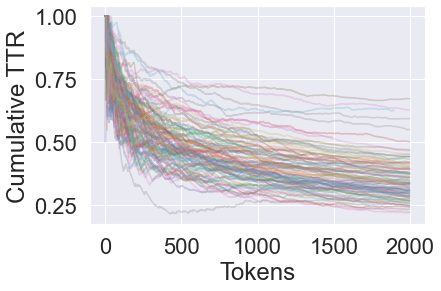

In [4]:
def TTR(x):
    return len(set(x)) / len(x)

def cumulative_TTR(words):
    out = [TTR(words[: i + 1]) for i in range(len(words))]
    return out

for i in range(0, 1000, 10):
    plt.plot(cumulative_TTR(df_bands.iloc[i].words[:2000]), alpha=0.3)
plt.xlabel('Tokens')
plt.ylabel('Cumulative TTR')
plt.show()

In [5]:
def MTLD_forward(words, threshold, verbose=False):
    factor = 0
    segment = []
    i = 0
    while i < len(words):
        segment.append(words[i])
        segTTR = TTR(segment)
        if verbose:
            print(i, segment, factor, segTTR)
        if segTTR <= threshold:
            segment = []
            factor += 1
        i += 1
    if len(segment) > 0:
        factor += (1.0 - segTTR) / (1.0 - threshold)
        if verbose:
            print(segment, factor)
    factor = max(1.0, factor)
    mtld = len(words) / factor
    return mtld


def MTLD(words, threshold=0.720, verbose=False):
    if len(words) == 0:
        return 0.0
    forward = MTLD_forward(words, threshold, verbose=verbose)
    reverse = MTLD_forward(words[::-1], threshold, verbose=verbose)
    return 0.5 * (forward + reverse)

In [6]:
def get_lexical_diversity(data):
    N = data.words.apply(len)
    V = data.words.apply(lambda x: len(set(x)))
    data['N'] = N
    data['V'] = V
    data['TTR'] = V / N
    data['rootTTR'] = V / np.sqrt(N)
    data['logTTR'] = np.log(V) / np.log(N)
    data['mtld'] = data.words.apply(MTLD, threshold=0.5)
    data['logmtld'] = np.log(data['mtld'])
    return data[data.N > 0]

In [7]:
df_bands = get_lexical_diversity(df_bands)
df_songs = get_lexical_diversity(df_songs)

C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Histograms

In [8]:
def plot_histograms(data):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Lexical diversity of heavy metal artists", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    logNmin, logNmax = np.log10(data.N.min()), np.log10(data.N.max())
    logbins = np.logspace(logNmin, logNmax, 20)
    data.N.hist(bins=logbins, edgecolor='k', ax=ax)
    ax.set_xscale('log')
    ax.set_title("Vocabulary sizes")
    ax.set_xlabel("N (tokens)")
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

    ax = axes[1]
    data.TTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{TTR} = V/N}$")

    ax = axes[2]
    data.rootTTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Root type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{rootTTR}} = \sqrt{V/N}$")

    ax = axes[3]
    data.logTTR.hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{logTTR}} = \log V / \log N$")

    ax = axes[4]
    data.logmtld[data.logmtld > -np.inf].hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    ax = axes[5]
    ax.axis('off')

    for ax in axes:
        ax.set_ylabel("Artists", rotation=0, labelpad=40)
        ax.grid(None)
        ax.grid(axis='y', color='k')

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

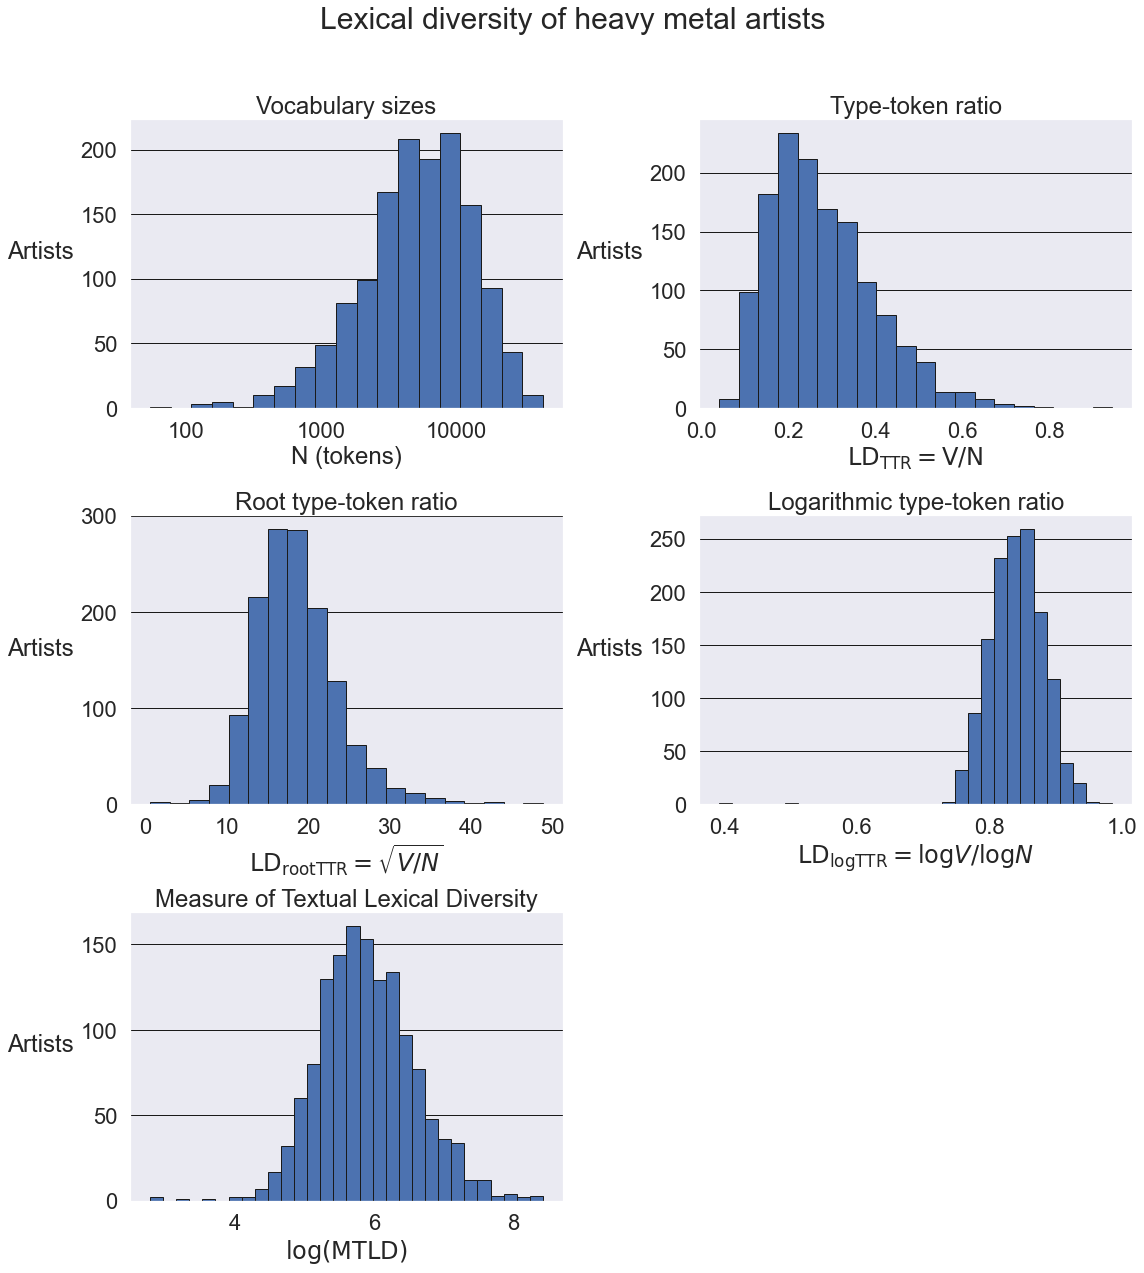

In [9]:
plot_histograms(df_bands)

# Violin plots

In [10]:
def plot_violinplots(data, figsize=(16, 18)):

    def violinplot(col, ax):
        violindata = []
        labels = data.columns[:list(data.columns).index('lyrics')]
        for label in labels:
            values = data[data[label] == 1][col]
            values = values[(values > -np.inf) & (values < np.inf)]
            violindata.append((label, values))
        violindata.sort(key=lambda x: -x[1].median())
        plot_labels, plot_data = zip(*violindata)
        sns.violinplot(data=plot_data, cut=0, orient='h', ax=ax, color='c')
        ax.set_yticklabels(plot_labels)
        return

    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    violinplot('N', ax)
    ax.set_title("Word counts")
    ax.set_xlabel("N (tokens)")

    ax = axes[1]
    violinplot('V', ax)
    ax.set_title("Unique word counts")
    ax.set_xlabel("V (types)")

    ax = axes[2]
    violinplot('TTR', ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

    ax = axes[3]
    violinplot('logTTR', ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

    ax = axes[4]
    violinplot('logmtld', ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    ax = axes[5]
    ax.axis('off')

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

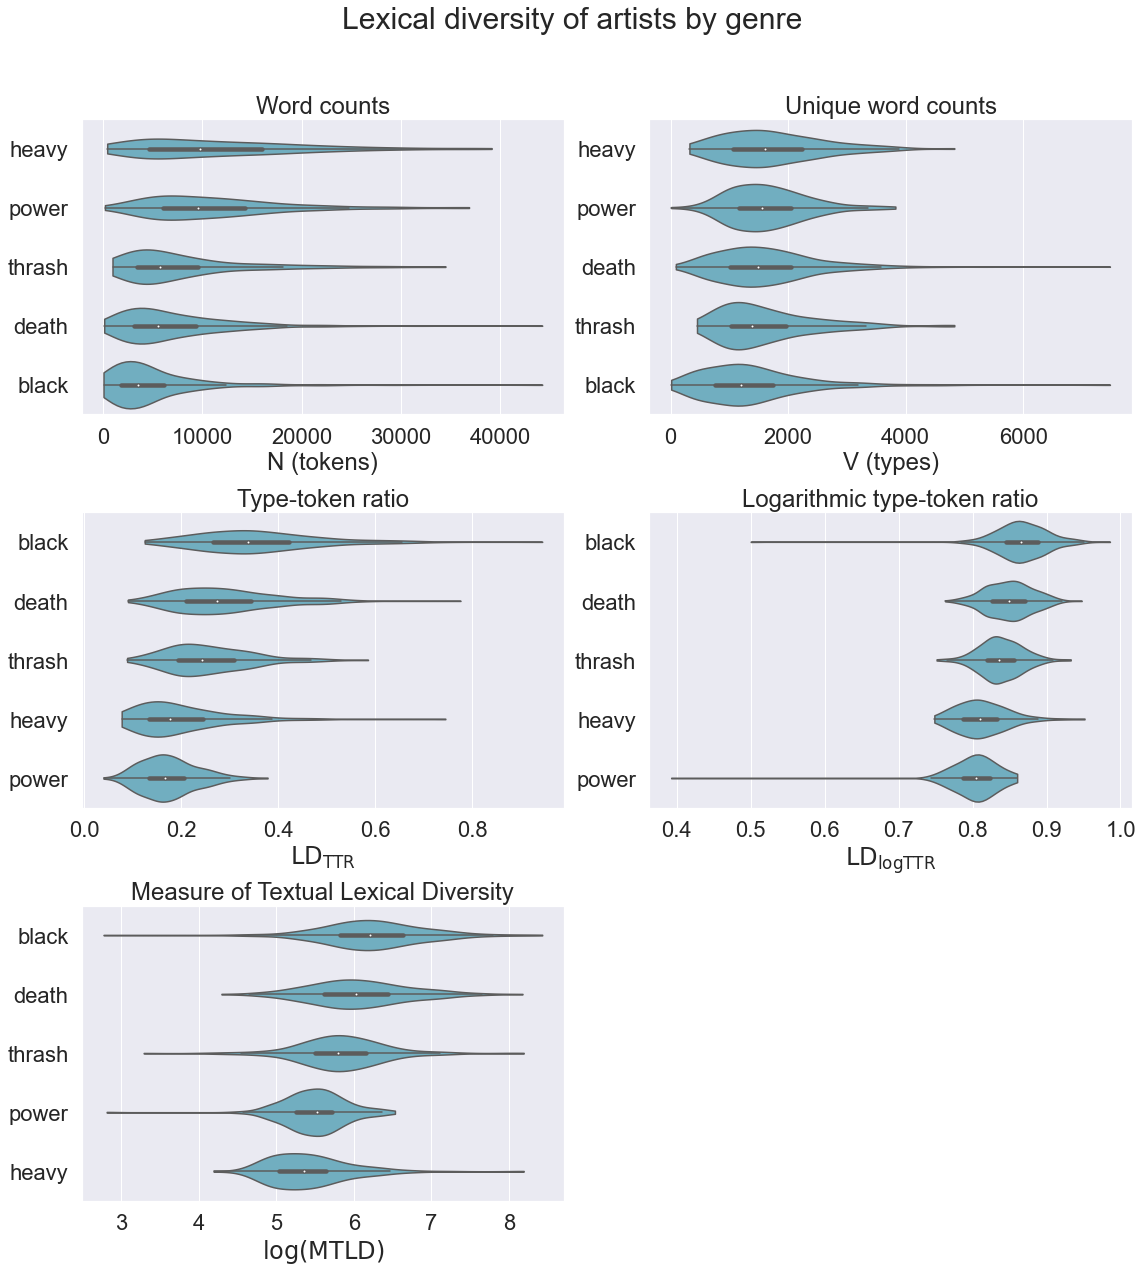

In [11]:
plot_violinplots(df_bands, figsize=(16, 18))

Several of the highest MTLD scores come from Bal-Sagoth songs. These are inflated as discussed in [Part 1](./lyrics0.ipnby): [Bal-Sagoth's lyrics](http://www.darklyrics.com/lyrics/balsagoth/thechthonicchronicles.html#4) consist of entire chapters of prose that are not actually sung in the songs themselves. Apart from this, The song with the highest MTLD is a 6-minute track by the Hungarian folk metal band Dalriada, [Zách Klára](http://www.darklyrics.com/lyrics/dalriada/aranyalbum.html#1).

In [12]:
df_songs.sort_values('mtld', ascending=False)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld
5826,Bal-Sagoth,The Obsidian Crown Unbound,1,0,0,0,0,"\n\n\nFrom Sage Daelun's ""Chronicles of Antedi...","[from, sage, daelun, chronicles, of, antediluv...",2391,993,0.415307,20.307640,0.887044,914.286940,6.818144
5825,Bal-Sagoth,Six Score and Ten Oblations to a Malefic Avatar,1,0,0,0,0,\n\n\n\nI have come into possession of a certa...,"[i, have, come, into, possession, of, a, certa...",840,453,0.539286,15.629985,0.908292,840.000000,6.733402
13134,Dalriada,Zách Klára,0,0,0,0,0,"\nRossz időket érünk,\nRossz csillagok járnak....","[rossz, időket, érünk, rossz, csillagok, járna...",799,467,0.584481,16.521272,0.919646,799.000000,6.683361
56670,Ulver,Stone Angels,1,0,0,0,0,"\n\n\nAngels go - we\nmerely stray, image of\n...","[angels, go, -, we, merely, stray, image, of, ...",769,418,0.543563,15.073466,0.908262,769.000000,6.645091
5797,Bal-Sagoth,Summoning the Guardians of the Astral Gate,1,0,0,0,0,\nIt is written in the ancient legends... that...,"[it, is, written, in, the, ancient, legends, t...",759,404,0.532279,14.664271,0.904918,759.000000,6.632002
13137,Dalriada,Ágnes asszony (1. rész),0,0,0,0,0,\nÁgnes asszony a patakban\nFehér lepedőjét mo...,"[ágnes, asszony, a, patakban, fehér, lepedőjét...",744,393,0.528226,14.408079,0.903474,744.000000,6.612041
5791,Bal-Sagoth,To Dethrone the Witch-Queen of Mytos K'unn (Th...,1,0,0,0,0,"\n\nThe vast armies of Mytos K'unn, marshalle...","[the, vast, armies, of, mytos, k'unn, marshall...",1413,621,0.439490,16.520399,0.886656,741.826206,6.609115
5830,Bal-Sagoth,Unfettering the Hoary Sentinels of Karnak,1,0,0,0,0,\n\nWhen Blackthorne returns from his expediti...,"[when, blackthorne, returns, from, his, expedi...",1344,627,0.466518,17.102827,0.894153,730.723404,6.594035
12000,Cradle of Filth,Beneath the Howling Stars,1,1,0,0,0,\nMidwinter wrongs the rites of Spring\nHer sp...,"[midwinter, wrongs, the, rites, of, spring, he...",706,426,0.603399,16.032721,0.922987,706.000000,6.559615
5806,Bal-Sagoth,Blood Slakes the Sand at the Circus Maximus,1,0,0,0,0,\n\n\n\n\n Hearken! The Ninth Legion has been ...,"[hearken, the, ninth, legion, has, been, put, ...",1280,586,0.457813,16.379198,0.890798,701.022680,6.552540


The bottom of the chart is mostly populated by very short, usually one-word, songs. Of songs with at least ten words, the honor of least lyrically diverse song goes to none other than the magnificently linguistically efficient "Thunderhorse" by Dethklok, which consists of the words "ride", "thunder", "horse", "revenge", and of course "thunderhorse", uttered a total of 33 times altogether. Why say lot word when few do trick?

In [13]:
df_songs[df_songs.N > 10].sort_values('mtld', ascending=True)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld
15830,Dethklok,Thunderhorse,0,1,0,0,0,\nRide...\nRide...\nRide...\nRide...\n\nThunde...,"[ride, ride, ride, ride, thunder, thunder, thu...",33,5,0.151515,0.870388,0.460299,2.952632,1.082697
43268,Putrid Pile,Toxic Shock Therapy,0,1,0,0,0,\nBe be oh be be be oh be be be\nOh be ah ah a...,"[be, be, oh, be, be, be, oh, be, be, be, oh, b...",18,3,0.166667,0.707107,0.380094,3.300000,1.193922
5552,Axxis,Journey to Utopia,0,0,1,1,0,"\n\n\nHey, hey, hey Utopia\nHey, hey, hey Utop...","[hey, hey, hey, utopia, hey, hey, hey, utopia,...",15,2,0.133333,0.516398,0.255958,3.750000,1.321756
29618,Katatonia,Dancing December,0,1,0,0,0,\nDance away...\nDance away...\nDance away...\...,"[dance, away, dance, away, dance, away, dance,...",12,2,0.166667,0.577350,0.278943,4.000000,1.386294
32219,Lost Society,Fatal Anoxia,0,0,0,0,1,\nFATAL ANOXIA\r\nFATAL ANOXIA\r\nFATAL ANOXIA...,"[fatal, anoxia, fatal, anoxia, fatal, anoxia, ...",15,2,0.133333,0.516398,0.255958,4.090909,1.408767
32664,M.O.D.,Bubble Butt,0,0,0,0,1,\nBubble Butt\r\nBubble Butt\r\nBubble Butt\r\...,"[bubble, butt, bubble, butt, bubble, butt, bub...",25,5,0.200000,1.000000,0.500000,4.166667,1.427116
14023,Dawnbringer,Scream and Run,1,0,1,0,0,\nScream and run\nScream and run\nScream and r...,"[scream, and, run, scream, and, run, scream, a...",51,3,0.058824,0.420084,0.279415,5.435374,1.692928
12314,Crimson Moonlight,Voistinu Voskrese,1,1,0,0,0,\nChristos Voskrese…Voistinu Voskrese!\nChrist...,"[christos, voskrese, voistinu, voskrese, chris...",12,3,0.250000,0.866025,0.442114,6.000000,1.791759
53365,The Great Kat,Metal Messiah,0,0,0,0,1,\nI'm your savior\nI'm your God\nWE SHALL OVER...,"[i'm, your, savior, i'm, your, god, we, shall,...",83,20,0.240964,2.195285,0.677945,6.545110,1.878718
60875,Yob,Lungs Reach,0,0,0,0,0,\nLungs reach\nLungs reach\nLungs reach\nLungs...,"[lungs, reach, lungs, reach, lungs, reach, lun...",22,4,0.181818,0.852803,0.448488,6.666667,1.897120


In [14]:
df_bands.sort_values('mtld', ascending=False)[:20]

,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld
band_name,,,,,,,,,,,,,,
Lucifugum,1,0,0,0,0,\nпротив шерсти рогатой луны\nв ямах рыхлого т...,"[против, шерсти, рогатой, луны, в, ямах, рыхло...",4569,2629,0.575399,38.893767,0.934415,4569.000000,8.427050
Azaghal,1,0,0,0,0,\nPimeyden seurakunta kokoontuu häväistyyn kir...,"[pimeyden, seurakunta, kokoontuu, häväistyyn, ...",7277,3369,0.462966,39.493427,0.913398,3839.616231,8.253128
Horna,1,0,0,0,0,"\n...Vanhoihin synkkiin ajatuksiin.\n\n""Ash na...","[vanhoihin, synkkiin, ajatuksiin, ash, nazg, d...",3794,2363,0.622826,38.363221,0.942546,3794.000000,8.241176
Stam1na,0,0,1,0,1,\nKuka tekee kaikki maailman peilit?\nNo sehän...,"[kuka, tekee, kaikki, maailman, peilit, no, se...",9785,4827,0.493306,48.797423,0.923098,3599.019946,8.188417
Hail of Bullets,0,1,0,0,0,\nHear the engines roaring\nHear the grinding ...,"[hear, the, engines, roaring, hear, the, grind...",3544,1867,0.526806,31.361546,0.921581,3544.000000,8.173011
Malignancy,0,1,0,0,0,\nFrom vaginal sores seep fetid secretions \r\...,"[from, vaginal, sores, seep, fetid, secretions...",5530,2094,0.378662,28.158798,0.887315,3110.126557,8.042419
Abusiveness,1,0,0,0,0,\nLook at the deadly sign of this face\nMarked...,"[look, at, the, deadly, sign, of, this, face, ...",3007,1702,0.566013,31.037937,0.928935,3007.000000,8.008698
Demolition Hammer,0,0,0,0,1,\nProgressive evolution\nSpawns a hybrid breed...,"[progressive, evolution, spawns, a, hybrid, br...",2845,1665,0.585237,31.215702,0.932640,2845.000000,7.953318
The Stone,1,0,0,0,0,\nDugo niko ne prolazi putem\nSto prepreci les...,"[dugo, niko, ne, prolazi, putem, sto, prepreci...",4669,2270,0.486185,33.221093,0.914642,2715.050177,7.906566


# Scatter plots

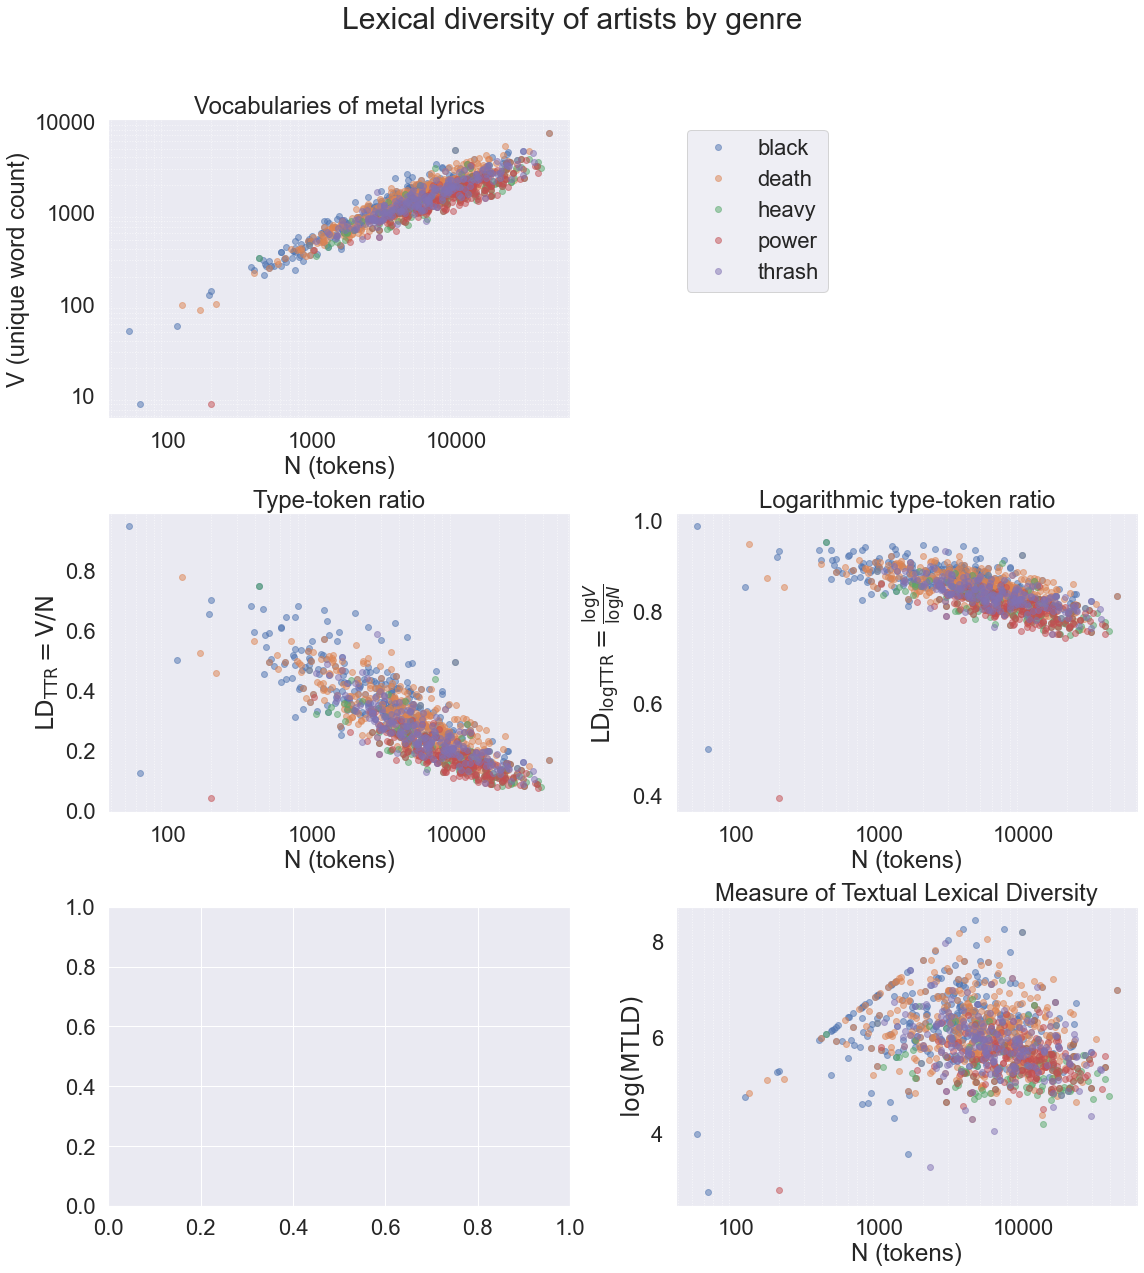

In [15]:
genres = df_bands.columns[:list(df_bands.columns).index('lyrics')]

def lexical_diversity_scatterplot(col, ax):
    for genre in genres:
        subset = df_bands[df_bands[genre] > 0]
        ax.plot(subset['N'], subset[col], 'o', markeredgewidth=1, alpha=0.5, label=genre)
    ax.set_xlabel("N (tokens)")
    ax.grid(axis='both', which='major')
    ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
    return

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
axes = axes.flatten()

ax = axes[0]
lexical_diversity_scatterplot('V', ax)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_ylabel("V (unique word count)")

ax = axes[1]
ax.axis('off')
for genre in genres:
    ax.plot([], [], 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.legend(frameon=True, loc='upper left')

ax = axes[2]
lexical_diversity_scatterplot('TTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Type-token ratio")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$")

ax = axes[3]
lexical_diversity_scatterplot('logTTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Logarithmic type-token ratio")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$")

ax = axes[4]

ax = axes[5]
lexical_diversity_scatterplot('logmtld', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Measure of Textual Lexical Diversity")
ax.set_ylabel(r"$\log(\mathrm{MTLD})$")

fig.tight_layout(rect=[0, 0, 1, 0.95])

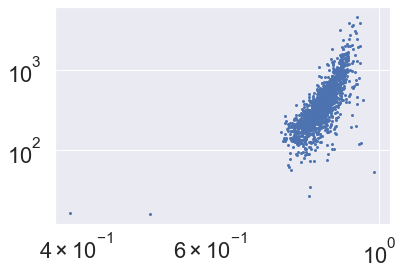

In [16]:
plt.plot(df_bands.logTTR, df_bands.mtld, '.')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Violin plots with expanded genres dataset

In [17]:
df_exp = pd.read_csv('songs-1pct.csv')
df_exp_bands = get_bands(df_exp)
df_exp_bands = get_lexical_diversity(df_exp_bands)

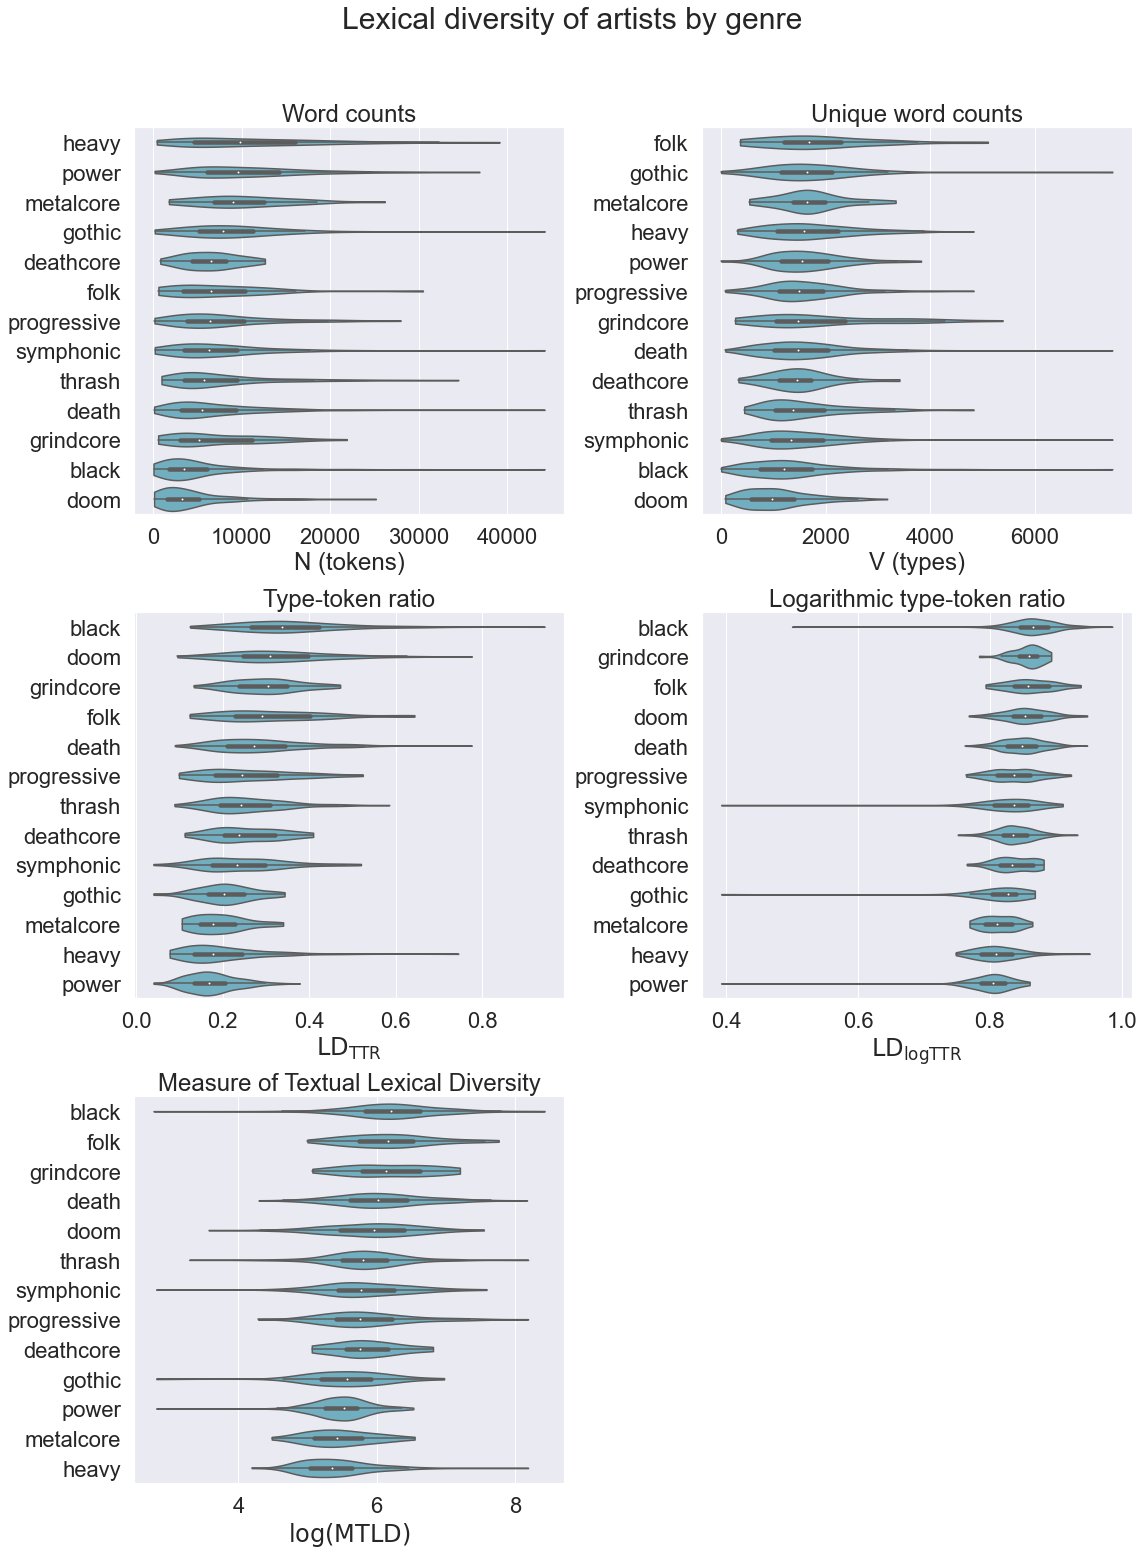

In [18]:
plot_violinplots(df_exp_bands, figsize=(16, 22))